## Using Prejudice Remover to Test Impact of Eta

**Goals:**
* Which samples get different predictions under different classifiers? 

* Which samples get different decisions (difficult decisions/samples).

* How much change induced onto eta will make the classifier produce different decisions?

* Create plot of changing eta over sample classification.

**Output:**
* Output CSV for test set for PrejudiceRemover, for each eta add a column of predictions for each different value of eta for that sample.

* Ability to pick 2 features, scattered the samples of that feature, and ability to move the slider (eta) with samples changing real-time.

**Notes:**
* Eta is 1 - fairness and accuracy are equal.


First, I will set up a prejudice_remover algorithm in order to make sure I understand the process of how it works, and if I can set it up correctly. 

In [1]:
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from aif360.metrics import BinaryLabelDatasetMetric

pip install 'aif360[LFR]'


In [2]:
# Split data into test and train, label as necessary
data = load_preproc_data_compas()
# For protected attribute sex, Female is privileged, and Male is unprivileged
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
# Split at 70/30
data_train, data_test = data.split([0.7], shuffle=True)

In [23]:
# Looking at our dataset
# Shape of data
train_features = data_train.features
print(data_train.features.shape)
# Labels of data
print(data_train.favorable_label, data_train.unfavorable_label)
# Attribute names (protected)
print(data_train.protected_attribute_names)
# Attribute values (protected)
print(data_train.privileged_protected_attributes, 
      data_train.unprivileged_protected_attributes)
# Feature names
print(data_train.feature_names)

(3694, 10)
0.0 1.0
['sex', 'race']
[array([1.]), array([1.])] [array([0.]), array([0.])]
['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


Splitting original data for later.

In [4]:
# Original training data
metric_orig_train = BinaryLabelDatasetMetric(data_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [5]:
# Original testing data
metric_orig_test = BinaryLabelDatasetMetric(data_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

Preparing logistic regression model.

In [59]:
# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(data_train.features)
y_train = data_train.labels.ravel()
y_test = data_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

LogisticRegression()

#### Accuracy of the model :

0.6702761234434218


#### F1 score of the model :

0.6387900355871886


<IPython.core.display.Javascript object>


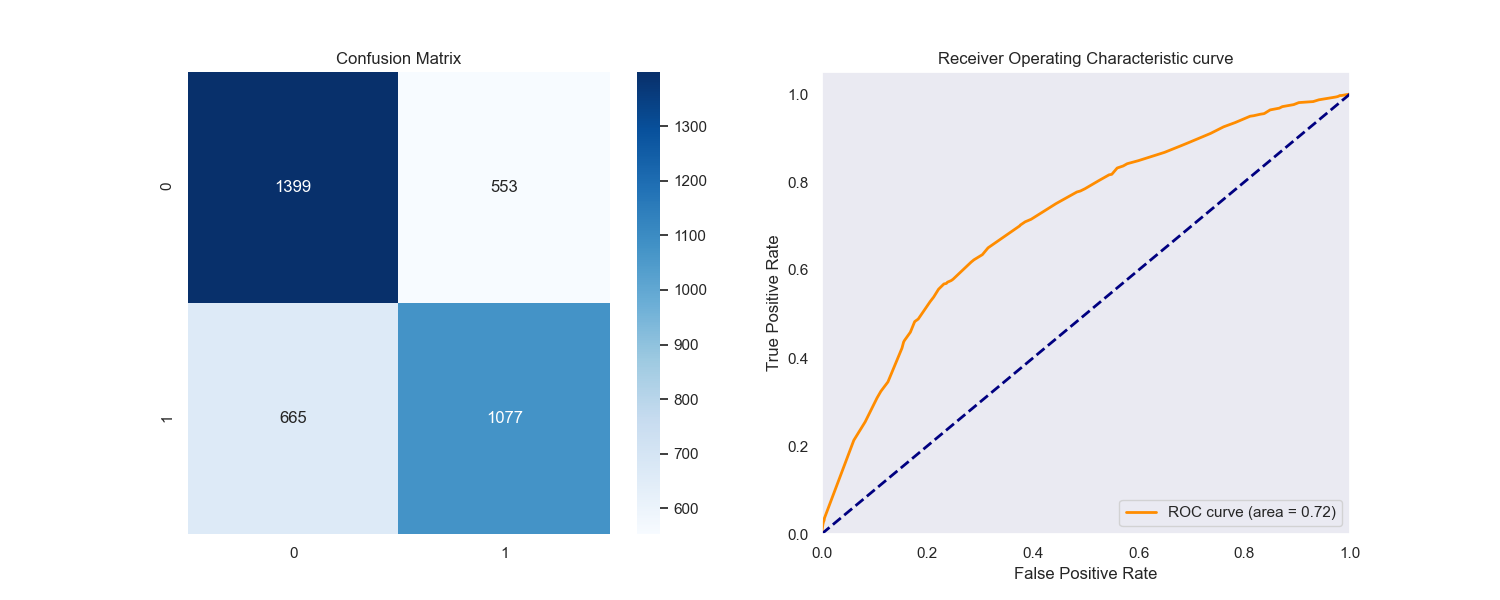

In [68]:
from sklearn.metrics import roc_curve, auc
plot_model_performance(lmod, X_train, y_test)

Preparing Random Forest Model

In [69]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

#### Accuracy of the model :

0.6553030303030303


#### F1 score of the model :

0.6094420600858369


<IPython.core.display.Javascript object>


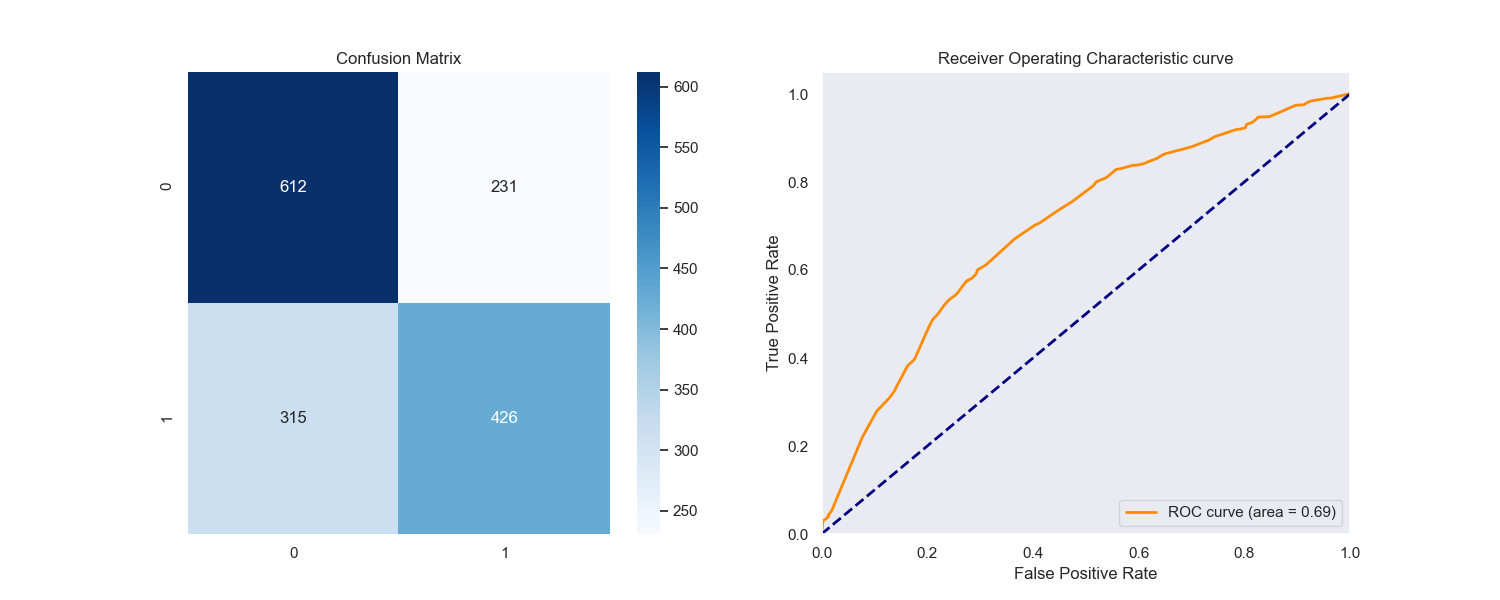

In [71]:
X_test_rfc = data_test.features
y_test_rfc = data_test.labels.ravel()
plot_model_performance(rfc, data_test.features, y_test_rfc)

Preparing the prejudice remover model.

In [7]:
# Using prejudice remover
pr = PrejudiceRemover(eta=1.0, sensitive_attr='sex')
pr.fit(data)

In [29]:
# Make predictions
y_pred = pr.predict(data)
print(y_pred)

               instance weights            features                        \
                                protected attribute                         
                                                sex race age_cat=25 to 45   
instance names                                                              
3                           1.0                 0.0  0.0              1.0   
4                           1.0                 0.0  0.0              0.0   
8                           1.0                 0.0  1.0              1.0   
10                          1.0                 1.0  1.0              1.0   
14                          1.0                 0.0  1.0              1.0   
...                         ...                 ...  ...              ...   
10994                       1.0                 0.0  0.0              1.0   
10995                       1.0                 0.0  0.0              0.0   
10996                       1.0                 0.0  0.0              0.0   

In [88]:
from aif360.metrics import ClassificationMetric
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [89]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [90]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

<IPython.core.display.Javascript object>


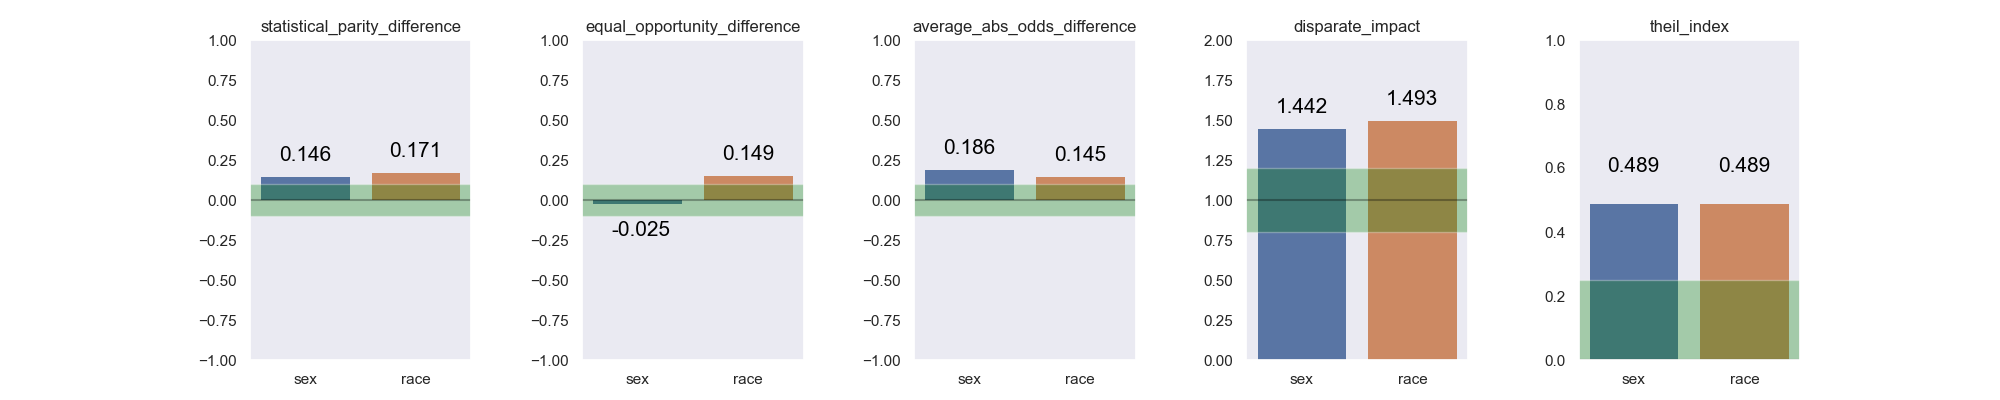

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the sex attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

#### For the race attribute :

With default thresholds, bias against unprivileged group detected in **5** out of 5 metrics

statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
sex                             0.145981                     -0.024717   
race                            0.170960                      0.148702   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000     0.000000  
sex                           0.186415          1.442238     0.488981  
race                          0.145240          1.493124     0.488981

In [92]:
import pandas as pd
debiased_model = PrejudiceRemover(sensitive_attr="sex", eta = 25.0)
debiased_model.fit(data_train)

fair = get_fair_metrics_and_plot(data_test, debiased_model, plot=True, model_aif=True)
data_pred = debiased_model.predict(data_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')

In [93]:
print(algo_metrics)

                                                              model  \
PrejudiceRemover  <aif360.algorithms.inprocessing.prejudice_remo...   
PrejudiceRemover  <aif360.algorithms.inprocessing.prejudice_remo...   

                                                       fair_metrics  \
PrejudiceRemover             statistical_parity_difference  equa...   
PrejudiceRemover             statistical_parity_difference  equa...   

                                                         prediction  \
PrejudiceRemover  [[1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1....   
PrejudiceRemover  [[1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1....   

                                                              probs  
PrejudiceRemover  [[0.5741419967450293], [0.70112090174902], [0....  
PrejudiceRemover  [[0.5741419967450293], [0.70112090174902], [0....  


Comparing to different classifiers

Getting and plotting model performance

In [56]:
# source: tds, gh, kaggle
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

<IPython.core.display.Javascript object>


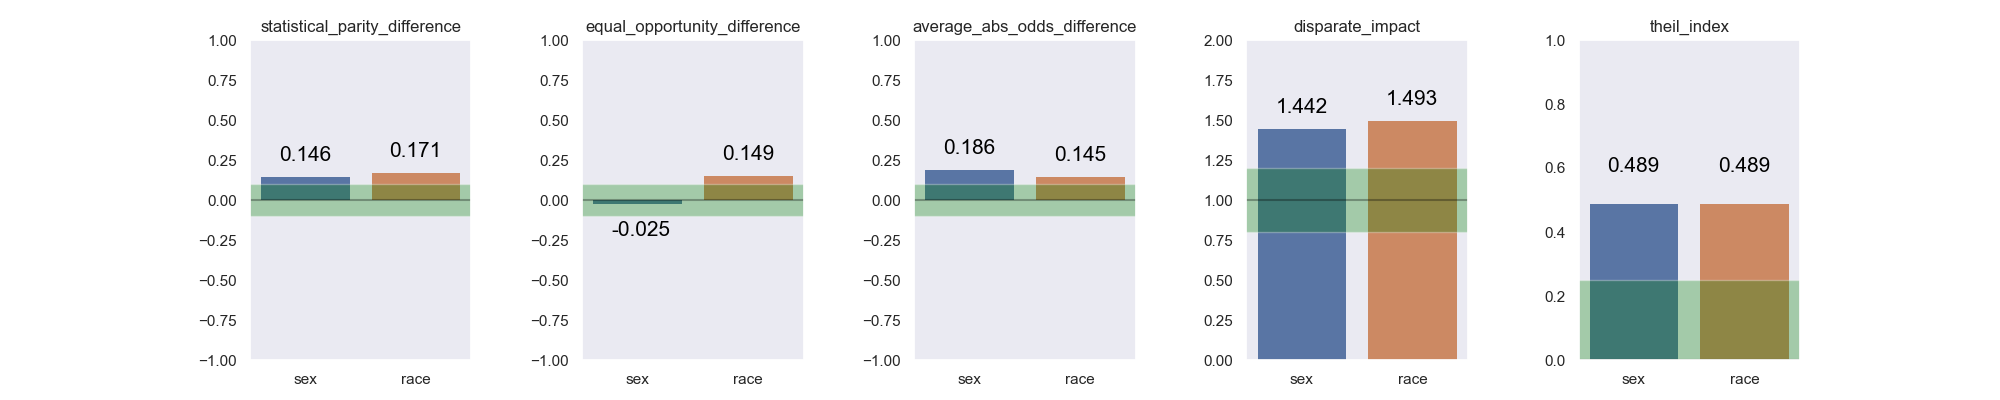

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the sex attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

#### For the race attribute :

With default thresholds, bias against unprivileged group detected in **5** out of 5 metrics

In [54]:
import seaborn as sns
from IPython.display import Markdown
import matplotlib.patches as patches
plot_fair_metrics(fair)

Creating PyWidget to control value of Eta
- ETA values 0-1
- What value of ETA changes the classifier?

In [11]:
# Imports
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Looking at different values of ETA and their metrics.

In [97]:
# Redefining test value
X_test = data_test.features
y_test= data_test.labels.ravel()

<IPython.core.display.Javascript object>


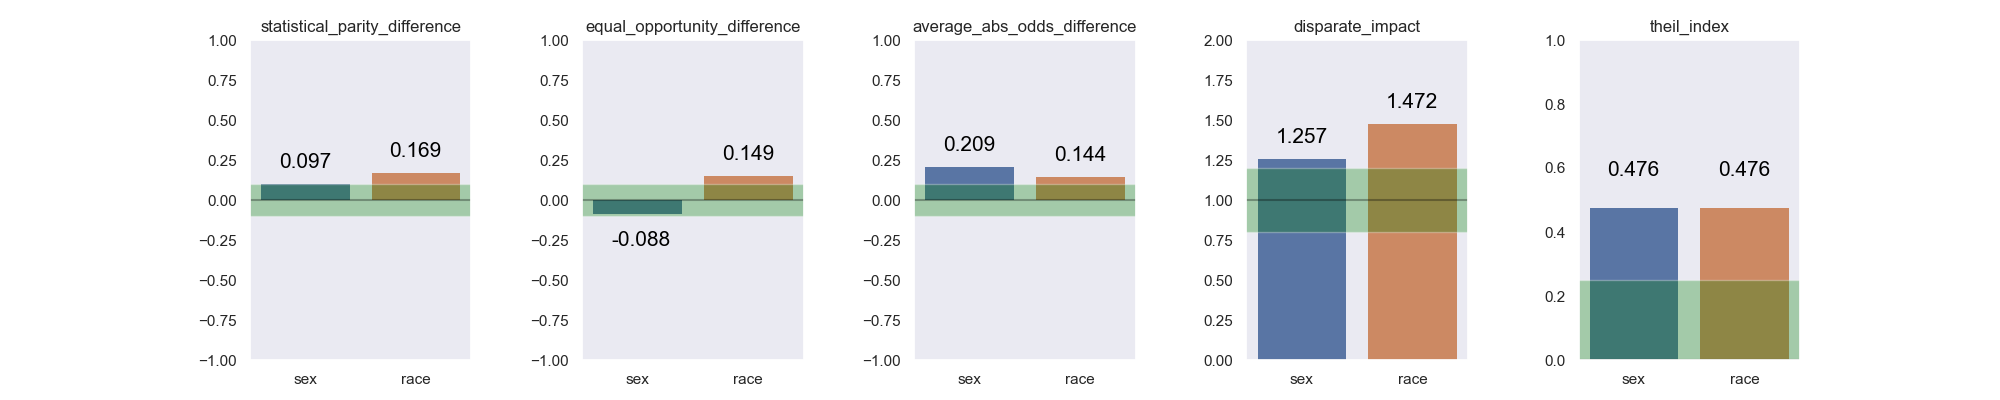

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the sex attribute :

With default thresholds, bias against unprivileged group detected in **3** out of 5 metrics

#### For the race attribute :

With default thresholds, bias against unprivileged group detected in **5** out of 5 metrics

statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
sex                             0.097438                     -0.088442   
race                            0.168730                      0.148991   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000      0.00000  
sex                           0.208754          1.257335      0.47648  
race                          0.144462          1.472008      0.47648

In [96]:
debiased_model1 = PrejudiceRemover(sensitive_attr="sex", eta = 250.0)
debiased_model1.fit(data_train)

fair1 = get_fair_metrics_and_plot(data_test, debiased_model1, plot=True, model_aif=True)
data_pred1 = debiased_model1.predict(data_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model1, fair1, data_pred.labels, data_pred.scores, 'PrejudiceRemover')